In [107]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

In [108]:
# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None)
print(cc_apps.head())

  0      1      2  3  4  5  6     7  8  9   10 11   12 13
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  g    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  g  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  g  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  g    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  s    0  +


What's interesting with this dataset, being a data file, there are no column headers. However, we can make one critical assumptions: column index 13 contains a + for approval. Let's confirm the types of values that exist in that column, and also explore the dataset's stats.

In [109]:
print(cc_apps.describe())
print(cc_apps.info())

               2           7          10             12
count  690.000000  690.000000  690.00000     690.000000
mean     4.758725    2.223406    2.40000    1017.385507
std      4.978163    3.346513    4.86294    5210.102598
min      0.000000    0.000000    0.00000       0.000000
25%      1.000000    0.165000    0.00000       0.000000
50%      2.750000    1.000000    0.00000       5.000000
75%      7.207500    2.625000    3.00000     395.500000
max     28.000000   28.500000   67.00000  100000.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-

In [110]:
print(cc_apps[13].value_counts())

-    383
+    307
Name: 13, dtype: int64


We see that a minus sign defines a credit card rejection. It's worth noting that the numeric columns may have outliers. There is no missing data, however. Let's examine the outliers.

In [111]:
numeric_cols = [2, 7, 10, 12]
cat_cols = [0, 1, 3, 4, 5, 6, 8, 9, 11]

z_scores = np.abs(stats.zscore(cc_apps[numeric_cols]))
outliers_mask = z_scores > 3
outliers_count = outliers_mask.sum()
print(outliers_count)

2     10
7     22
10     8
12     6
dtype: int64


It looks like there is a handful of outliers, but based on the context of credit card applications, it is feasible that these columns could have outlier data rather than be due to bad data entry or other errors. We'll leave them in the dataset, but will utilize the Robust Scaler rather than Standard Scaler to help mitigate the impact of outliers on the Logistic Regression and K Neighbors Classifier models.

We will also include Random Forest and Gradient Boosting classifier models, which are more robust to outliers.

Let's now explore the value counts for each of the categorical columns.

In [112]:
for col in cat_cols:
    print(cc_apps[col].value_counts())

b    468
a    210
?     12
Name: 0, dtype: int64
?        12
22.67     9
20.42     7
18.83     6
24.50     6
         ..
48.25     1
28.33     1
18.75     1
18.50     1
36.42     1
Name: 1, Length: 350, dtype: int64
u    519
y    163
?      6
l      2
Name: 3, dtype: int64
g     519
p     163
?       6
gg      2
Name: 4, dtype: int64
c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25
j      10
?       9
r       3
Name: 5, dtype: int64
v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6
n       4
o       2
Name: 6, dtype: int64
t    361
f    329
Name: 8, dtype: int64
f    395
t    295
Name: 9, dtype: int64
g    625
s     57
p      8
Name: 11, dtype: int64


It looks like question marks are representing missing data. These should be nullified and imputed. The imputing will occur within the pipeline.

Column 1 appears to contain float values but was registered as an object due to the question mark, so that will be converted nullifying the question marks.

In [113]:
cc_apps = cc_apps.replace('?', np.NaN)
cc_apps[1] = cc_apps[1].astype(float)
print(cc_apps.head())

  0      1      2  3  4  5  6     7  8  9   10 11   12 13
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  g    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  g  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  g  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  g    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  s    0  +


Since column 13 is our target variable, we'll remove it for the X features and set it for our y feature, then split the dataset into training and testing sets.

In [114]:
X = cc_apps.drop(13, axis=1).values
y = cc_apps[13]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

We will also need to redeclare the numeric and categorical columns after changing column 1 to float.

In [115]:
numeric_features = [1, 2, 7, 10, 12]
categorical_features = [0, 3, 4, 5, 6, 8, 9, 11]

We'll instantiate the preprocessing step, including the imputing strategies (mean for numerical columns and mode for categorical columns), scaling, and one-hot encoding. We'll include the RobustScaler due to the outliers.

In [116]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

Now we can instantiate the 5 models. There was a convergence issue with the logistic regression model, so I included the max_iter=5000 parameter and added classifier tolerance. We also have each model's parameters for hyperparameter tuning using GridSearchCV.

In [117]:
models = {
    'Logistic Regression': (LogisticRegression(random_state=seed, max_iter=5000), [
        {
            'classifier__C': np.arange(0.001, 1.1, 0.1),
            'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
            'classifier__tol': [1e-4, 1e-3, 1e-2]
        }
    ]),
    'KNN': (KNeighborsClassifier(), [
        {
            'classifier__n_neighbors': np.arange(1, 25, 3)
        }
    ]),
    'Decision Tree': (DecisionTreeClassifier(random_state=seed), [
        {
            'classifier__max_depth': [None, 10, 20, 30, 40, 50],
            'classifier__min_samples_leaf': [1, 2, 5, 10, 20],
            'classifier__max_features': [None, 'sqrt', 'log2']
        }
    ]),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=seed), [
        {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    ]),
    'Random Forest': (RandomForestClassifier(random_state=seed), [
        {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5, 10]
        }
    ])
}

We'll use KFold to assist with cross validation, using 5 folds. We also instantiate an empty dictionary to store each model's results.

In [118]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

best_models = {}

We will use the parameter grid and model names from the models dictionary to declare our pipeline, which will perform the preprocessing steps defined earlier for each model. GridSearchCV will perform the hyperparameter tuning for accuracy.

In [119]:
for model_name, (model, param_grid) in models.items():
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"{model_name}: Best Parameters: {grid_search.best_params_}, Best CV Score: {grid_search.best_score_}")


Logistic Regression: Best Parameters: {'classifier__C': 0.7010000000000001, 'classifier__solver': 'liblinear', 'classifier__tol': 0.01}, Best CV Score: 0.8695876288659793
KNN: Best Parameters: {'classifier__n_neighbors': 19}, Best CV Score: 0.8404853951890034
Decision Tree: Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 5}, Best CV Score: 0.8592568728522336
Gradient Boosting: Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}, Best CV Score: 0.8613187285223367
Random Forest: Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}, Best CV Score: 0.8757731958762885
Logistic Regression: Best Parameters: {'classifier__C': 0.7010000000000001, 'classifier__solver': 'liblinear', 'classifier__tol': 0.01}, Best CV Score: 0.8695876288659793
KNN: Best Parameters: {'classifier__n_neighbors': 19}, Best CV Scor

Now we can print the details and identify our best performing model.

In [120]:
# Get the best model and its parameters
best_model_name = max(best_models, key=lambda k: best_models[k]['best_score'])
best_model_info = best_models[best_model_name]
best_model_cv_score = best_model_info['best_score']
best_model = best_model_info['best_estimator']
best_params = grid_search.best_params_
best_score = best_model.score(X_test, y_test)

print("Best model:", best_model_name)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_model_cv_score)
print("Test Score:", best_score)

Best model: Random Forest
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best Cross-Validation Score: 0.8757731958762885
Test Score: 0.8405797101449275
Best model: Random Forest
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best Cross-Validation Score: 0.8757731958762885
Test Score: 0.8405797101449275


We see that the Random Forest model performs best. We measured for accuracy, but let's look at the confusion matrix to understand how this model classified the credit card applications.

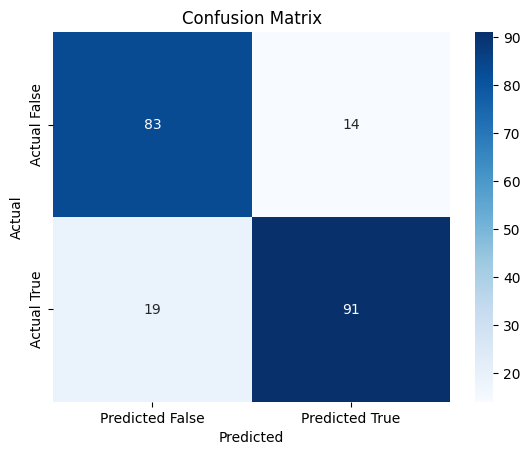

In [123]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Looks like the model does a great job at correctly predicting both approved and rejected applications, making this model a strong fit for this business case.

In [122]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")


Test Accuracy: 0.8405797101449275
Test Precision: 0.8418584825234442
Test Recall: 0.8405797101449275
Test F1 Score: 0.8407287533047781
Test Accuracy: 0.8405797101449275
Test Precision: 0.8418584825234442
Test Recall: 0.8405797101449275
Test F1 Score: 0.8407287533047781


## Results
The Random Forest ensemble mmodel performs best on this data set, producing an accuracy score of 87.58% on the training set and 84.06% on the testing set, well above the required 75% for the project. It performs strongly for correctly predicting approvals and rejections equally. Its accuracy, precision, recall, and f1 score on the test set are all at 84%.